# 6 GLMの応用範囲を広げる -ロジスティック回帰など-

In [1]:
using CSV
using DataFrames
using GLM
using Plots
using StatsBase

## 6.2 例題 : 上限のあるカウントデータ

In [2]:
df = CSV.read("data4a.csv");

In [3]:
df

,N,y,x,f
,Int64⍰,Int64⍰,Float64⍰,String⍰
1,8,1,9.76,C
2,8,6,10.48,C
3,8,5,10.83,C
4,8,6,10.94,C
5,8,1,9.37,C
6,8,1,8.81,C
7,8,3,9.49,C
8,8,6,11.02,C
9,8,0,7.97,C


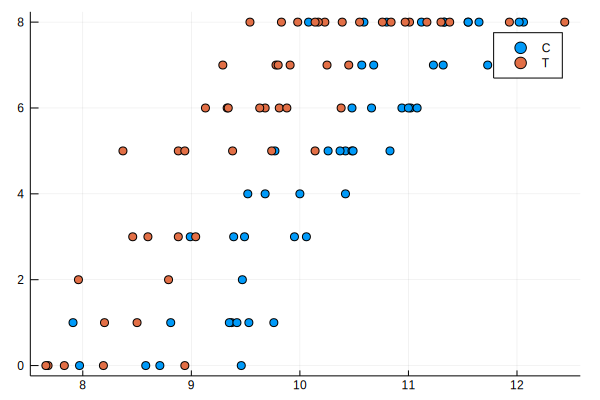

In [4]:
plot(df.x, df.y, group=df.f, seriestype=:scatter)

In [5]:
describe(df)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Int64,DataType
1,N,8.0,8,8.0,8,,0,Int64
2,y,5.08,0,6.0,8,,0,Int64
3,x,9.9672,7.66,9.965,12.44,,0,Float64
4,f,,C,,T,2,0,String


## 6.4 ロジスティック回帰とロジットリンク関数

In [6]:
function logistic(z)
    1 / (1 + exp(-z))
end

logistic (generic function with 1 method)

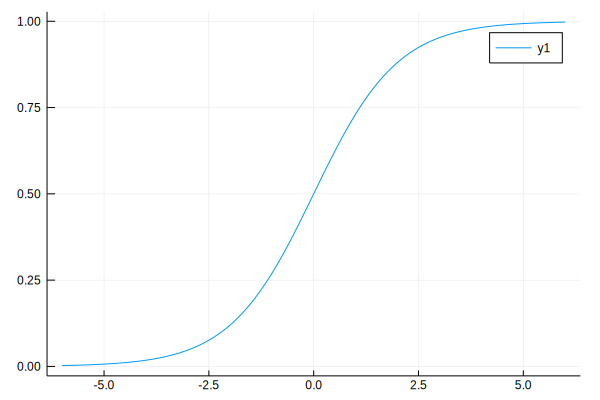

In [7]:
z = -6:0.1:6
plot(z, logistic.(z))

### 6.4.2 パラメータ推定
Juliaでは、Binomial分布の場合、応答変数はfractionにしなければならない  
https://github.com/JuliaStats/GLM.jl/issues/228#issuecomment-387340111

In [8]:
df.yy = df.y ./ df.N
result = glm(@formula(yy ~ x + f), df, Binomial(), wts=fill(8.0, nrow(df)))

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: yy ~ 1 + x + f

Coefficients:
             Estimate Std.Error  z value Pr(>|z|)
(Intercept)  -19.5361   1.41331 -13.8229   <1e-42
x             1.95241  0.138827  14.0636   <1e-44
f: T          2.02151  0.231233  8.74227   <1e-17


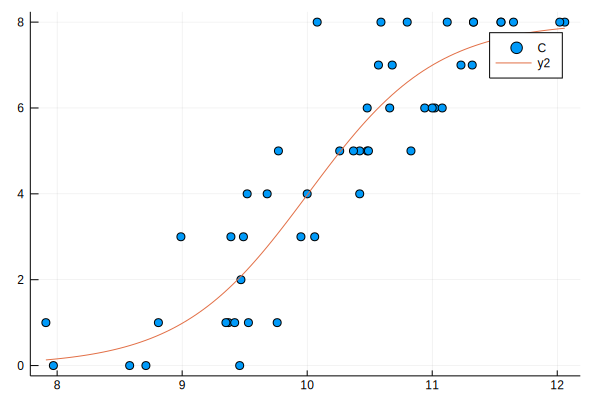

In [9]:
dfc = df[df.f .== "C", :];
plot(dfc.x, dfc.y, seriestype=:scatter, label="C")
xx = DataFrame(x=range(minimum(dfc.x), maximum(dfc.x), length=100), f="C")
yy = predict(result, xx) * 8.0
plot!(xx.x, yy)

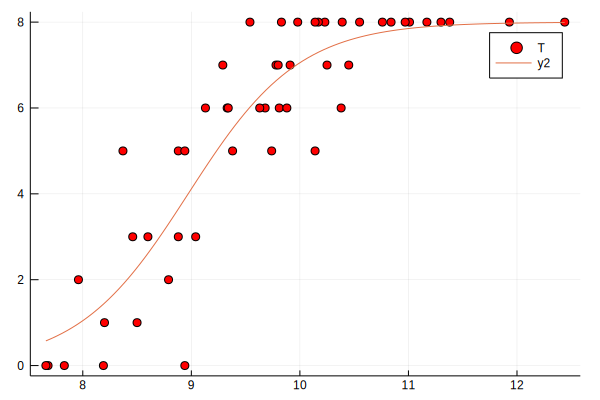

In [10]:
dft = df[df.f .== "T", :];
plot(dft.x, dft.y, seriestype=:scatter, label="T", color=:red)
xx = DataFrame(x=range(minimum(dft.x), maximum(dft.x), length=100), f="T")
yy = predict(result, xx) * 8.0
plot!(xx.x, yy)

In [11]:
typeof(result)

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

### 6.4.4 ロジスティック回帰のモデル選択
$k, \log L^*, \mbox{deriance} - 2\log L^*, \mbox{residual deviance}, \mbox{AIC}$

In [12]:
function model_selection_table(result)
    dof(result), loglikelihood(result), -2loglikelihood(result), deviance(const_model), aic(result)
end

model_selection_table (generic function with 1 method)

In [13]:
const_model = glm(@formula(yy ~ 1), df, Binomial(), wts=fill(8.0, nrow(df)))
model_selection_table(const_model)

(1, -321.204670831189, 642.409341662378, 499.23210267844786, 644.409341662378)

In [14]:
f_model = glm(@formula(yy ~ 1 + f), df, Binomial(), wts=fill(8.0, nrow(df)))
model_selection_table(f_model)

(2, -316.8798767283339, 633.7597534566678, 499.23210267844786, 637.7597534566678)

In [15]:
x_model = glm(@formula(yy ~ 1 + x), df, Binomial(), wts=fill(8.0, nrow(df)))
model_selection_table(x_model)

(2, -180.17272164185795, 360.3454432837159, 499.23210267844786, 364.3454432837159)

In [16]:
xf_model = glm(@formula(yy ~ 1 + x + f), df, Binomial(), wts=fill(8.0, nrow(df)))
model_selection_table(xf_model)

(3, -133.1055646426136, 266.2111292852272, 499.23210267844786, 272.2111292852272)

## 6.5 交互作用項の入った線形予測子

In [17]:
interaction_model = glm(@formula(yy ~ x + f + x * f), df, Binomial(), wts=fill(8.0, nrow(df)))

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: yy ~ 1 + x + f + x & f

Coefficients:
               Estimate Std.Error    z value Pr(>|z|)
(Intercept)    -18.5233   1.88592   -9.82192   <1e-22
x               1.85251  0.185555    9.98361   <1e-22
f: T         -0.0637455   2.70222 -0.0235901   0.9812
x & f: T       0.216335   0.27993   0.772819   0.4396


In [18]:
model_selection_table(interaction_model)

(4, -132.80529836304297, 265.61059672608593, 499.23210267844786, 273.61059672608593)

## 6.6 割算値の統計モデリングはやめよう

In [19]:
df_population = CSV.read("data4b.csv")

,y,x,A
,Int64⍰,Float64⍰,Float64⍰
1,57,0.68,10.3
2,64,0.27,15.6
3,49,0.46,10.0
4,64,0.45,14.9
5,82,0.74,14.0
6,29,0.15,9.6
7,37,0.5,11.8
8,33,0.57,6.8
9,61,0.79,11.8


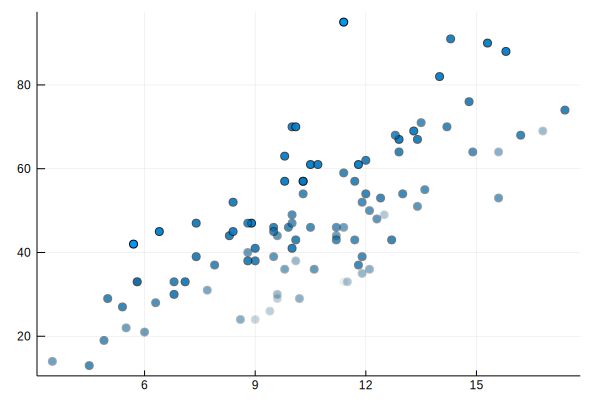

In [20]:
plot(df_population.A, df_population.y, seriestype=:scatter, markeralpha=df_population.x, label="")

オフセット項を考慮したGLM

In [21]:
population_reseult = glm(@formula(y ~ x), df_population, Poisson(), offset=log.(df_population.A))

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x

Coefficients:
             Estimate Std.Error z value Pr(>|z|)
(Intercept)  0.973082 0.0450494 21.6003   <1e-99
x             1.03827 0.0776913  13.364   <1e-40


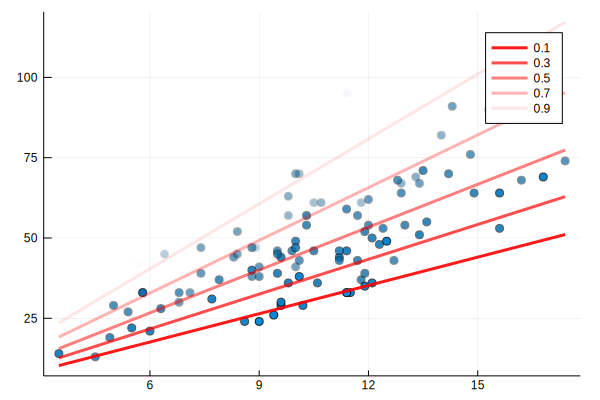

In [22]:
plt = plot(df_population.A, df_population.y, seriestype=:scatter, markeralpha=1 .- df_population.x, label="")
for j = 0.1:0.2:0.9
    xx = DataFrame(A=range(minimum(df_population.A), maximum(df_population.A), length=100), x=j)
    yy = predict(population_reseult, xx, offset=log.(xx.A))
    plot!(xx.A, yy, lw=3, color=:red, linealpha=1 - j, label=j)
end
display(plt)